In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
# Read Data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [3]:
spectra = spectrum_test.columns

In [4]:
def rename_columns(df):
    new_df = df
    for i in range(len(df.columns)):
        new_df.columns.values[i] = int(i)

    return new_df

In [5]:
spectrum_train_scaled = spectrum_train.multiply(10**12)
spectrum_test_scaled = spectrum_test.multiply(10**12)

In [6]:
# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 0

if direction:
    X_train = temp_train
    X_test = temp_test
    y_train = spectrum_train_scaled
    y_test = spectrum_test_scaled
else:
    X_train = spectrum_train_scaled
    X_test = spectrum_test_scaled
    y_train = temp_train
    y_test = temp_test

In [7]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [8]:
input_data = df_to_tensor(X_train)
output_data = df_to_tensor(y_train)

In [14]:
output_data

tensor([[ 0.1119,  0.0821,  0.0643,  ...,  0.3437,  0.3360,  0.3290],
        [ 0.1240,  0.0904,  0.0701,  ...,  0.3269,  0.3197,  0.3131],
        [ 0.1119,  0.0821,  0.0643,  ...,  0.3437,  0.3360,  0.3290],
        ...,
        [10.8134, 10.6301, 10.5865,  ..., 21.8142, 20.7956, 19.8604],
        [10.6221, 10.5147, 10.5277,  ..., 22.0530, 21.0220, 20.0754],
        [11.4288, 11.0081, 10.7881,  ..., 21.1053, 20.1236, 19.2221]])

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [10]:
input_size = len(X_train.columns)
output_size = len(y_train.columns)
model = Net(input_size=input_size, output_size=output_size)

In [11]:
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Rprop(model.parameters(), lr=0.001) 

In [12]:
num_epochs = 15
batch_size = 10
num_batches = len(input_data) // batch_size

for epoch in range(num_epochs):
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size

        inputs = input_data[start:end]
        targets = output_data[start:end]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

Epoch 1/15, Loss: 2.457315
Epoch 2/15, Loss: 1.860097
Epoch 3/15, Loss: 0.926559
Epoch 4/15, Loss: 0.947597
Epoch 5/15, Loss: 0.899691


KeyboardInterrupt: 

In [ ]:
pred = model(df_to_tensor(X_test))
pred = pd.DataFrame(pred.detach().numpy())

actual = y_test

In [ ]:
actual

,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,2.373538,2.602481,2.775814,2.935397,3.074856,3.220465,3.363583,3.505908,3.647634,3.790090,...,10.069020,10.146292,10.208057,10.243674,10.246583,10.192531,10.036903,9.737349,9.326093,8.947765
1,2.027413,2.150030,2.250785,2.362463,2.467873,2.581041,2.694600,2.809533,2.925638,3.043688,...,8.794491,8.871859,8.934365,8.973221,8.983096,8.942860,8.813263,8.556884,8.201778,7.875021
2,2.470590,2.726463,2.921211,3.095970,3.246416,3.402639,3.555543,3.706972,3.857192,4.007671,...,10.460966,10.538142,10.599540,10.633985,10.634567,10.576088,10.412293,10.099323,9.670691,9.276407
3,1.950271,2.046041,2.131383,2.233903,2.333012,2.440313,2.548641,2.658761,2.770347,2.884035,...,8.542764,8.620148,8.682729,8.722118,8.733251,8.695631,8.571070,8.323129,7.979041,7.662406
4,2.523524,2.771409,2.957469,3.126776,3.273742,3.426844,3.576945,3.725913,3.874010,4.022686,...,10.456130,10.533535,10.595041,10.629530,10.630143,10.571716,10.408014,10.095198,9.666764,9.272662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2.192934,2.265018,2.342720,2.448247,2.552709,2.666823,2.782449,2.900217,3.019629,3.141284,...,9.084417,9.163255,9.226302,9.264688,9.273079,9.229759,9.094268,8.828052,8.460122,8.121585
188,2.866444,3.111950,3.310165,3.497918,3.661790,3.833240,4.001578,4.168564,4.334260,4.500144,...,11.480967,11.560216,11.621472,11.652821,11.646998,11.576596,11.391136,11.042846,10.568600,10.132440
189,2.472189,2.595338,2.710352,2.843756,2.969493,3.104773,3.240354,3.377164,3.514802,3.654108,...,10.103905,10.184319,10.247445,10.283357,10.286093,10.231598,10.075142,9.774224,9.361201,8.981250
190,2.981718,3.256156,3.477688,3.682082,3.857959,4.041007,4.220010,4.396886,4.571775,4.746312,...,11.902925,11.981761,12.042309,12.072085,12.063454,11.987999,11.793489,11.430545,10.937430,10.483950


In [ ]:
pred

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,9.431863,9.303757,10.634909,9.521880,11.570946,12.778710,12.223081,13.348950,12.050779,13.747242,...,22.653938,23.112074,22.975599,20.381176,23.251482,22.396776,22.022558,20.543005,20.763422,17.984890
1,8.415187,8.663768,10.070045,9.111765,10.645594,12.094763,11.478523,12.281651,11.845624,12.757755,...,22.435028,21.711166,21.471916,19.816685,22.708288,20.211245,21.510363,20.098299,20.212927,18.160595
2,9.261180,9.174985,10.249780,9.186946,11.156190,12.243871,11.792618,12.860018,11.645849,13.199554,...,22.120070,22.540258,22.434078,19.798248,22.662811,21.928665,21.372887,19.972317,20.177193,17.404064
3,7.095000,8.058964,9.244711,7.775468,9.625539,11.030817,10.499720,11.047569,11.194922,11.541682,...,21.426222,20.177322,19.881615,18.656689,21.652288,17.976696,20.297754,19.079395,19.108105,17.289009
4,9.304918,8.964288,10.466908,8.836796,11.316553,12.577188,11.905087,13.010064,11.793629,13.385877,...,21.818048,22.687571,22.523684,19.883289,22.641953,22.052832,21.364985,19.681572,20.215221,16.832920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,5.894427,7.883660,8.218209,7.094637,8.502904,9.769496,9.439859,9.714958,10.536154,10.159007,...,21.302444,19.017797,18.684870,17.597115,21.080648,15.724669,19.263987,18.658365,18.240425,17.315292
188,8.515387,9.502589,9.627952,9.687344,10.467884,11.382127,11.326626,12.025648,11.561780,12.392307,...,23.337046,21.910906,21.981001,19.730408,23.090492,20.526520,21.607418,20.697191,20.252386,19.074263
189,7.584541,9.157522,9.192199,9.542373,9.933377,11.163412,10.800998,11.537331,11.544216,11.778492,...,23.574625,21.211523,21.004005,19.431007,23.004436,18.559538,21.444630,21.099503,20.154337,19.968634
190,7.432700,9.703431,9.440136,8.862240,10.413075,11.042574,11.227056,11.826030,11.351048,12.181901,...,23.458525,21.557154,21.722345,19.629269,23.206823,19.771734,21.621567,20.761425,20.120621,19.307297


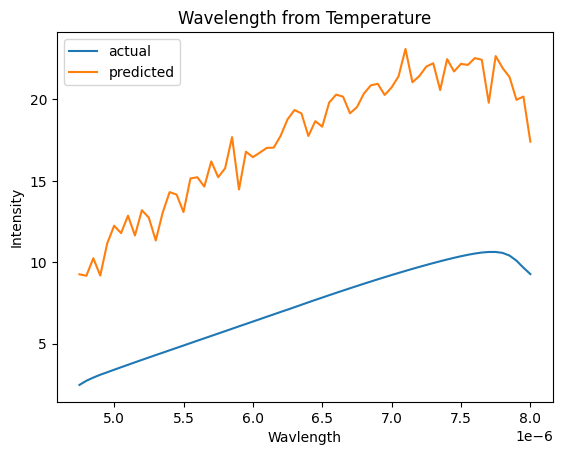

In [ ]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(actual))
plt.plot(y_train.columns, actual.values[2], label='actual')
plt.plot(y_train.columns, pred.values[2],  label='predicted')

if direction:
    plt.title("Wavelength from Temperature")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Temperature from Wavelength")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()